In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [3]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

# Creating dataset

In [4]:
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")

In [5]:
train_df = pd.concat([train_df, val_df, test_df])

# Defining training parameters

In [6]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [7]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [8]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [9]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [10]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [11]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Downloading ResNet50

In [12]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s] 


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Training tools

In [14]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training

In [15]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epochs 1 train loss 0.047211071415015606 acc 0.4299880999603332 val loss 0.03433243849920848 acc 0.45714285714285713
Epochs 2 train loss 0.024319725169496185 acc 0.6596588655295518 val loss 0.037193434389810716 acc 0.5206349206349207
Epochs 3 train loss 0.014881959691117653 acc 0.8119793732645776 val loss 0.02995075536152673 acc 0.6095238095238096
Epochs 4 train loss 0.010808858800293765 acc 0.8766362554541849 val loss 0.03482836579519605 acc 0.5873015873015873
Epochs 5 train loss 0.007885741276052537 acc 0.9139230464101546 val loss 0.028684965201786587 acc 0.707936507936508
Epochs 6 train loss 0.005128340478668795 acc 0.9428798095993653 val loss 0.024101600949726406 acc 0.7714285714285715
Epochs 7 train loss 0.004441711032384093 acc 0.9523998413328044 val loss 0.020298942781630018 acc 0.8031746031746032
Epochs 8 train loss 0.002218527757983473 acc 0.9793732645775486 val loss 0.023028706463556443 acc 0.8126984126984127
Epochs 9 train loss 0.0026163330638928222 acc 0.9714399047996827 va

# Model's performance log

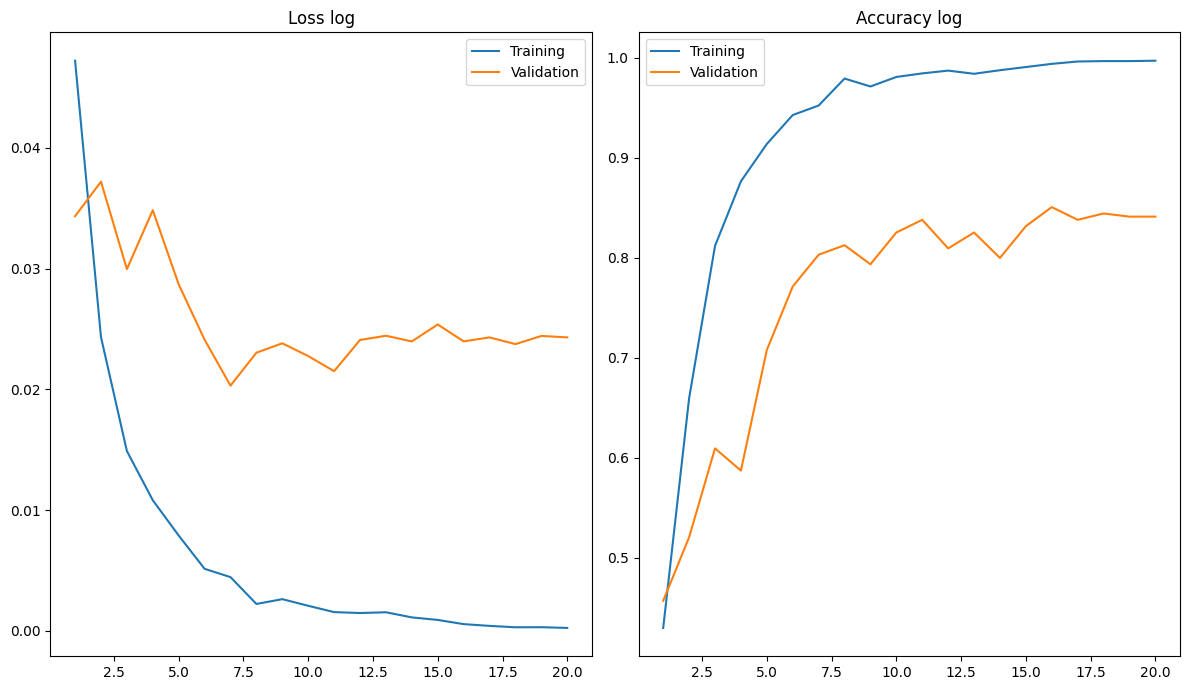

In [16]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [17]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [18]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

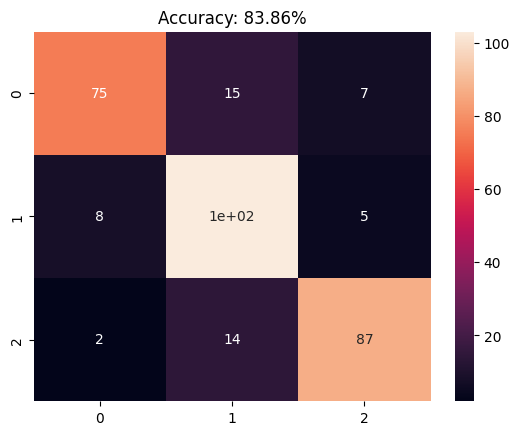

In [19]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [20]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        97
           1       0.78      0.89      0.83       116
           2       0.88      0.84      0.86       103

    accuracy                           0.84       316
   macro avg       0.85      0.84      0.84       316
weighted avg       0.84      0.84      0.84       316



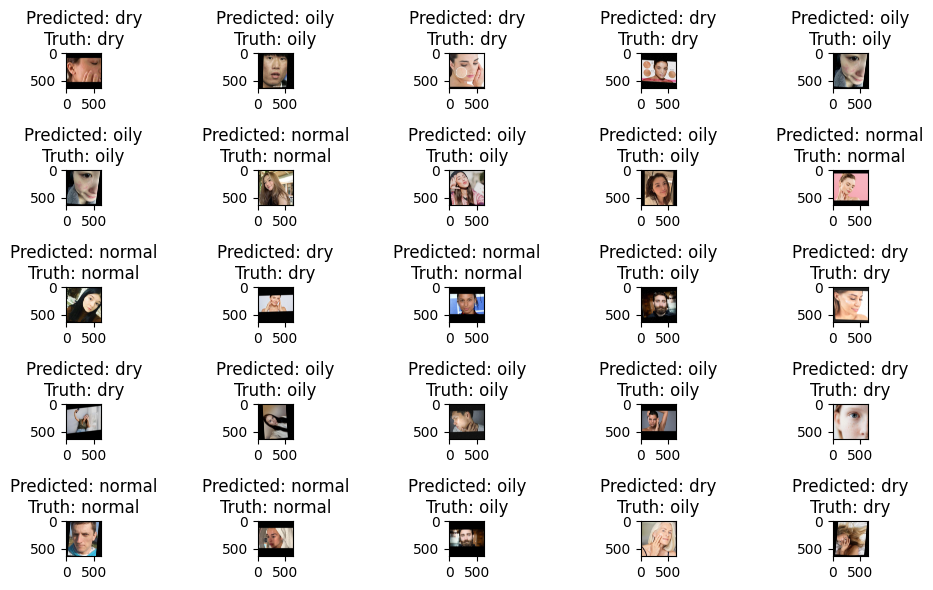

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()